# Machine Learning 1: Background and techniques

## Introduction
In the lecture I introduced some of the key ideas of machine learning. In today's practical class we explore these ideas further. I want to show you how easy it is to use python to explore the power of machine learning with minimal need for new code. Later today we will use python to implement a method from a recent materials science publication that uses machine learning to automatically classify microstructure.

In [2]:
# Import some modules that we will require
import numpy as np  
import scipy as sp
import sklearn # This is a module of machine learning tools

import matplotlib.pyplot as plt
% matplotlib inline

### Resources
As always, the best place to find help with coding is the web, via some judicious use of a search engine. There is also, of course, the python documentation. A good book is "Introduction to Machine Learning with Python", by Andreas C. Mueller, Sarah Guido. Many of the examples used in this notebook are adapted from this book.

![Image of expected classification of moon data](Images/Book.jpg "Title")

## Unsupervised learning
We'll begin by considering some examples of *unsupervised learning*. What is unsupervised learning? From Wikipedia: *"Unsupervised machine learning is the machine learning task of inferring a function to describe hidden structure from "unlabeled" data (a classification or categorization is not included in the observations)"*

#### <span style="color: red"> Comment: I'm not sure this Wikipedia definition is that enlightening - could we add our own definition using simpler terms?

### Cluster analysis: k-means clustering by hand
We begin by implementing a simple method by hand.

#### The problem
Let's assume that we have a bunch of data for a pair of properties for a number of samples. We won't worry for now about what these propeties are, but they could, in principle, be any kind of data, either continuous variables or category data. The methods we will use are also not restricted to two-dimensions: we could deal with many more properties at the same time.

#### <span style="color: red"> Comment: Could we give an example of the kind of data we might be interested in analysing?

Let's start by taking a look at the data:

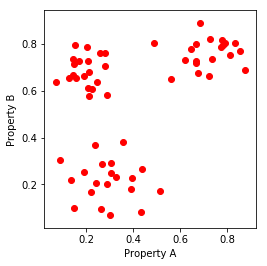

In [17]:
nclusters = 3
data = np.loadtxt('Data/clusterdata.txt', delimiter=',')
plt.scatter(data[:,0],data[:,1],marker='o', color='r')
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

There is clearly some structure to this data: our samples seem to fall into three distinct clusters. What we want to do now is have the computer automatically group the data into clusters. Broadly speaking this means finding groups of points such that the variation in the two properties within the group is minimised but the differences between the groups are maximised. To illustrate this process, we will now implement a method called *k-means clustering*. First of all, we will do this "by hand" so that we can understand what is going on. Later on we will use a built-in method of the scikit-learn module to demonstrate the power of this module.

#### The method
First of all we need to decide how many clusters we will ask the computer to define. In this case, the data clearly suggest that three clusters would be appropriate. Next we pick three data points at random from the dataset to serve as initial guesses for our cluster centres. Let's do that now and plot these cluster centres (as black triangles):

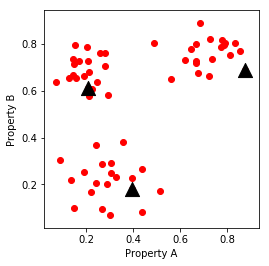

In [18]:
centres = data[np.random.randint(0,np.size(data,0),nclusters),:]
plt.scatter(data[:,0],data[:,1],marker='o', color='r')
plt.scatter(centres[:,0],centres[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

Now, there's a good chance that this random selection has not resulted in a particularly good choice for the cluster centres (Note: if, by chance, you did get a good choice of cluster centres, then I suggest you rerun the above cell until you get a *poor* choice. The next few cells will make more sense this way!). Couldn't we do better by choosing the cluster centres by hand? In this case, yes we could, but remember that we are aiming for an *unsupervised* learning method, in which we intervene as little as possible in the clustering process. Also, if the data set had many more dimensions it might not be easy to see initially where the cluster centres ought to lie.

The next stage of the process is to classify all the points into three clusters based on which of the initial cluster centres is the closest. To do this we will define a python function which takes the raw data and a list of cluster centres as input and populates an array of flags, one per data point, to indicate which cluster the point belongs to:

In [19]:
def classify(data,clusterid,centres):
    nclusters = np.size(centres,0)
    for i in range(np.size(data,0)):
        mind = 9999.0
        for s in range(nclusters):
            d = np.linalg.norm(data[i,:]-centres[s,:])
            if d < mind:
                mind = d
                clusterid[i] = s
    return

Let's now use this function and take a look at the result:

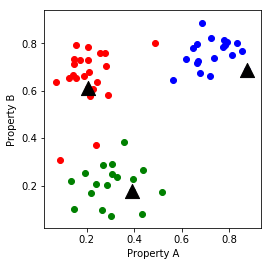

In [20]:
clusters = np.zeros(np.size(data,0), dtype=int) # Create an empty array to hold the cluster identities
classify(data,clusters,centres) # Run the clustering function

color = ['r','g','b']
for s in range(nclusters):
    plt.scatter(data[(clusters == s),0],data[(clusters == s),1],marker='o', color=color[s])
plt.scatter(centres[:,0],centres[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

Now, because our intial choice of cluster centres was not ideal the points will not be perfectly classified. We now move to the next stage of the algorithm, which first involves finding the centres of our newly defined (imperfect) clusters. This is simply the average value of the coordinates (the properties) of the points in each cluster. Let's implement a python function to do this:

In [21]:
def getcentres(data,clusterid,centres):
    nclusters = np.size(centres,0)
    count = np.zeros(nclusters, dtype=int)
    centres[:,:] = 0
    for i in range(np.size(data,0)):
        count[clusterid[i]] = count[clusterid[i]] + 1
        centres[clusterid[i]] = centres[clusterid[i]] + data[i,:]
    centres[:,0] = centres[:,0]/count[:]
    centres[:,1] = centres[:,1]/count[:]
    return

Now we will use this function to get the new centres of the clusters and plot them on top of the data:

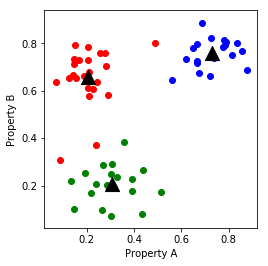

In [22]:
getcentres(data,clusters,centres)
for s in range(nclusters):
    plt.scatter(data[(clusters == s),0],data[(clusters == s),1],marker='o', color=color[s])
plt.scatter(centres[:,0],centres[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

These probably look like much better values for the cluster centres. Let's now repeat the proces of classifiying the points according to their distance from the new cluster centres and then finding the new cluster centres based on this classification. Because we put our code into functions, this is particularly easy to do:

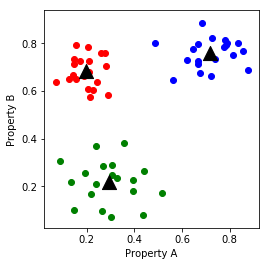

In [23]:
classify(data,clusters,centres)
getcentres(data,clusters,centres)
for s in range(nclusters):
    plt.scatter(data[(clusters == s),0],data[(clusters == s),1],marker='o', color=color[s])
plt.scatter(centres[:,0],centres[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

You should now, after only two interations of the clustering algorithm, have a reasonable solution. Just in case the clustering is still not perfect, we can now interate through the cluster assignment and centre determination process a few more times and check the result:

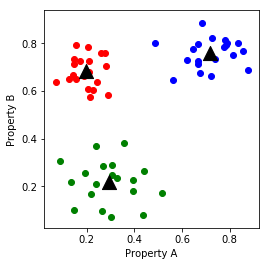

In [24]:
ntries = 10
for i in range(ntries):
    classify(data,clusters,centres)
    getcentres(data,clusters,centres)
for s in range(nclusters):
    plt.scatter(data[(clusters == s),0],data[(clusters == s),1],marker='o', color=color[s])
plt.scatter(centres[:,0],centres[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

This should now look pretty good, whatever the initial choice of cluster centres. 

#### <span style="color: red"> Task 1:</span> Try out some different initial choices for the cluster centres
Experiment by repeatedly running the cell that picks the inital centres at random until you get a really bad choice (e.g. all the centres within one cluster) and then rerun the remaining cells to see how quickly the result converges to the obviously correct answer.

### Using scikit-learn: k-means clustering the easy way

k-means clustering uses a simple and intuitive algorithm (which is why we chose it as an example), but some machine learning algorithms are much more complex and would require a lot of coding. This is just where python and its huge community of users and contributors comes into its own. Scikit-learn is a module that implements many of the most useful machine learning algorithms. As a first example of how to use it, we will repeat the process of k-means clustering of our example data. All we do is load the KMeans object from the module, create a KMeans object and then implement the fitting method on the object (we'll reload the data just to keep things clean):

In [25]:
from sklearn.cluster import KMeans
nclusters = 3
data = np.loadtxt('Data/clusterdata.txt', delimiter=',')
kmeans = KMeans(n_clusters = nclusters)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

After running the `.fit()` method the `kmeans` object now contains the results of the clustering process in the member variable `.labels_` and `.cluster_centers_` (note the US spelling of "centers"). We can access these variables and view the results of the clustering.

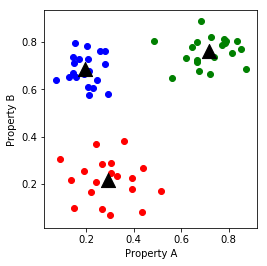

In [26]:
color = ['r','g','b']
for s in range(nclusters):
    plt.scatter(data[(kmeans.labels_ == s),0],data[(kmeans.labels_ == s),1],marker='o', color=color[s])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')
plt.axes().set_aspect('equal')

The results are equivalent to the ones we obtained above "by hand" and I think you will agree that this process is pretty painless!

### A trickier clustering example - using alternative algorithms

Above we used a carefully chosen data set that was amenable to clustering by the k-means method. Not all data will be so well behaved. To demonstate this, let's take a look at some more data:

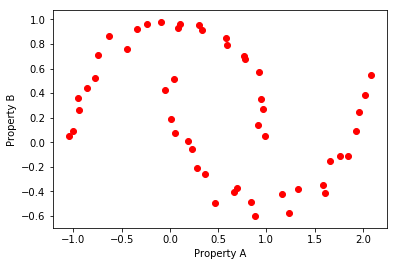

In [27]:
data = np.loadtxt('Data/moonclusterdata.txt', delimiter=',')
plt.scatter(data[:,0],data[:,1],marker='o', color='r')
plt.xlabel('Property A')
plt.ylabel('Property B')

This is an example of a classic data set used to test machine learning algorithms. The non-linearity in the dividing line between the two clusters makes this rather tricky to work with.

#### <span style="color: red"> Task 2:</span> Try out the k-means method (using scikit learn or our own `classify` and `getcentres` functions) to classify the data into two clusters.

#### <span style="color: red"> Solutions:</span>

[[ 1.96475185  0.24565207]
 [-0.85496846  0.44384714]]


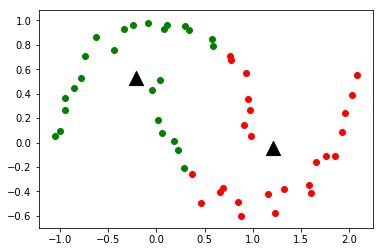

In [28]:
nclusters = 2
clusters = np.zeros(np.size(data,0), dtype=int)
centres = data[np.random.randint(0,np.size(data,0),nclusters),:]
print(centres)

ntries = 10
for i in range(ntries):
    classify(data,clusters,centres)
    getcentres(data,clusters,centres)
for s in range(nclusters):
    plt.scatter(data[(clusters == s),0],data[(clusters == s),1],marker='o', color=color[s])
plt.scatter(centres[:,0],centres[:,1],marker='^', color='k', s=200)

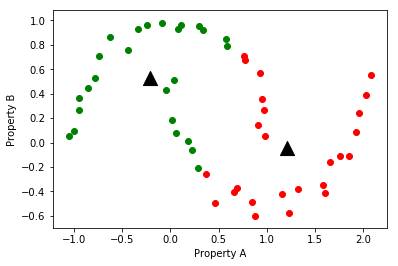

In [29]:
from sklearn.cluster import KMeans
nclusters = 2
kmeans = KMeans(n_clusters = nclusters)
kmeans.fit(data)

for s in range(nclusters):
    plt.scatter(data[(kmeans.labels_ == s),0],data[(kmeans.labels_ == s),1],marker='o', color=color[s])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')

You should find that the k-means clustering struggles to deal with the curved clusters, as below:

![Image of expected classification of moon data](Images/MoonKmeans.jpg "Title")

#### An alternative clustering algorithm: DBSCAN
Fortunately scikit-learn includes many different algorithms to try out and they are all easily accessible. To show how easy it is to use scikit-learn, the below cell contains code that uses the unsupervised learning algorithm DBSCAN to correctly cluster this trickier data set. I timed myself and managed to get this working from scratch in less than ten minutes. I think this demonstrates the power of python. The process that I went through was as follows:

1. Google the phrase: scikit learn clustering unsupervised.
2. Click on the link to the python documentation page on unsupervised learning (this was the first link in my case).
3. Click on the link "2.3. Clustering".
4. Look at the overview figure for something that looks like it would work on my data: DBSCAN looks like a good bet.
5. Have a quick read of the documentation and the example code: it looks like I will need to tune two parameters: epsilon and min_samples. I will also need a way to extract the number of clusters for plotting purposes.
6. Try out some code.
7. Tune the values of epsilon and min_samples to get the clustering correct.

#### <span style="color: red"> Comment: Could we explain roughly what eps and min_samples are?

It's a simple as that. Try out the resulting code below:

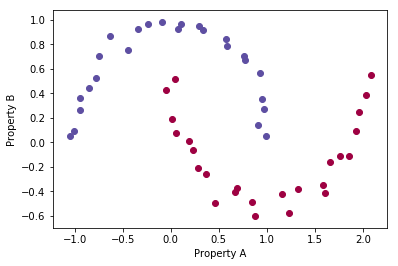

In [30]:
from sklearn.cluster import DBSCAN
data = np.loadtxt('Data/moonclusterdata.txt', delimiter=',')
db = DBSCAN(eps=0.4, min_samples=2).fit(data)
nclusters = len(set(db.labels_))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, nclusters)]
for s in range(nclusters):
    plt.scatter(data[(db.labels_ == s),0],data[(db.labels_ == s),1],marker='o', color=colors[s])
plt.xlabel('Property A')
plt.ylabel('Property B')

#### <span style="color: red"> Task 3:</span>  Try our some alternative values of epsilon and min_samples and observe the results.

#### <span style="color: red"> Solution:</span>  

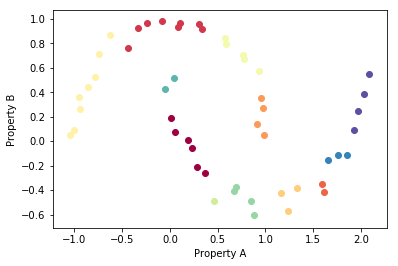

In [31]:
db = DBSCAN(eps=0.2, min_samples=1).fit(data)
nclusters = len(set(db.labels_))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, nclusters)]
for s in range(nclusters):
    plt.scatter(data[(db.labels_ == s),0],data[(db.labels_ == s),1],marker='o', color=colors[s])
plt.xlabel('Property A')
plt.ylabel('Property B')

You will find that the DBSCAN algorithm needs careful tuning, but is at least capable of coping with the curved boundary between clusters.

## Supervised  learning

In contrast to the unsupervised learning above, *"Supervised learning is the machine learning task of inferring a function from labeled training data"* (Wikipedia). Let's explore some examples.

### Learning preassigned classes: a support vector machine 
As an example of supervised learning we will take another look at our moon-shaped data, but this time we will assume that the data represent samples drawn from two different types (perhaps two types of materials) and that we know to which type each point belongs. The below code loads in the data, along with a list of the type for each point, and plots the result:

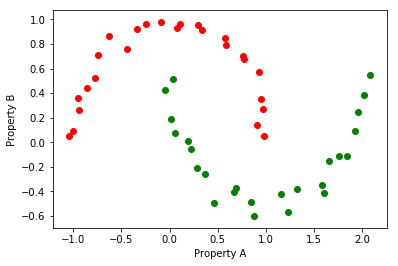

In [32]:
trainingdata = np.loadtxt('Data/moonclusterdata.txt', delimiter=',')
trainingclasses = np.loadtxt('Data/moonclusterclasses.txt', delimiter=',')

nclusters = 2
color = ['r','g','b']
for s in range(nclusters):
    plt.scatter(trainingdata[(trainingclasses == s),0],data[(trainingclasses == s),1],marker='o', color=color[s])
plt.xlabel('Property A')
plt.ylabel('Property B')

We are going to use this data, which consists of pairs of input properties along with known classes, to train a kind of classifier known as a *support vector machine* (SVM). This data is referred to as *training data*. 

To train a SVM on our data all we need to do is run the following code:

In [33]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=100, gamma=1.0).fit(trainingdata,trainingclasses)

That's all there is to it! (although note that I did need to tune the values of `C` and `gamma`: I'll come back to that in a minute). You might have noticed that in the above example I am creating the `svm` object and calling the fitting method in a single line: this is a very compact syntax. 

Now that now we have trained our SVM, we can use it to *predict* the classes of some further data. In this case, I have prepared another set of data for which we know the class of each point. This is a set of *test data*. The data was not used in training the SVM, so we can see how well the SVM does predicting the classes of these new samples and visualise the result:

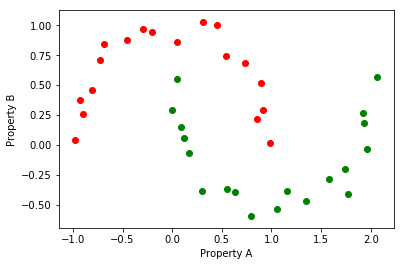

In [34]:
testdata = np.loadtxt('Data/moonclustertestdata.txt', delimiter=',')
predictedclasses = svm.predict(testdata)

for s in range(nclusters):
    plt.scatter(testdata[(predictedclasses == s),0],testdata[(predictedclasses == s),1],marker='o', color=color[s])
plt.xlabel('Property A')
plt.ylabel('Property B')

This looks like a reasonable job, but let's check by comparing the predictions with the actual classes of the test data (which I saved at the time of generating the data):

In [35]:
testclasses = np.loadtxt('Data/moonclustertestclasses.txt', delimiter=',')
print('Percentage correctly classified: ' + str(np.sum(testclasses==predictedclasses)/np.size(testclasses)*100) + '%')
print(testclasses==predictedclasses)

Percentage correctly classified: 97.2972972973%
[ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


We can see that the 4th point has been classified incorrectly. Let's use a plot to see which point this is:

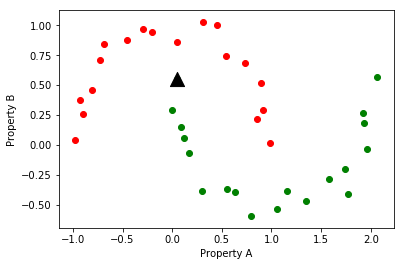

In [36]:
for s in range(nclusters):
    plt.scatter(testdata[(predictedclasses == s),0],testdata[(predictedclasses == s),1],marker='o', color=color[s])
plt.scatter(testdata[(predictedclasses != testclasses),0],testdata[(predictedclasses != testclasses),1], marker='^', color='k', s=200)
plt.xlabel('Property A')
plt.ylabel('Property B')

The incorrectly classified point is indicated by the triangular marker. To work out what has gone wrong we can visualise the *decision boundary* that is used to determine the classes of different points in our two-dimensional property space. The code below does this. There is no need to worry too much about the details (creating the contour is a bit fiddly!).

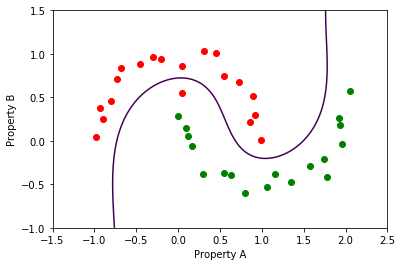

In [37]:
X1, X2 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.0, 1.5, 100))
X_grid = np.c_[X1.ravel(), X2.ravel()]
decision_values = svm.decision_function(X_grid)
fill_levels = [decision_values.min()] + [0] + [
            decision_values.max()]

for s in range(nclusters):
    plt.scatter(testdata[(testclasses == s),0],testdata[(testclasses == s),1],marker='o', color=color[s])
plt.xlabel('Property A')
plt.ylabel('Property B')
ax = plt.gca()
ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=[0])

In the above plot I have coloured the points according to the correct classification. You will see that the problematic point falls on the wrong side of the decision boundary. This is always a possibility and highlights the importance of using a test set of data to measure the performance of a trained classifier. Another reason for using a test set is the issue of *over-fitting* which we will return to shortly when we look at neural networks.

#### Tuning the SVM
I mentioned above that I needed to tune the parameters of the SVM in order to achieve good results. The SVM takes two parameters: `C` and `gamma`, which control the shape and smoothness of the decision boundary.

#### <span style="color: red"> Task 4:</span>   Explore the effect on the decision boundary of changing the parameters of the SVM. I have included the necessary code below.

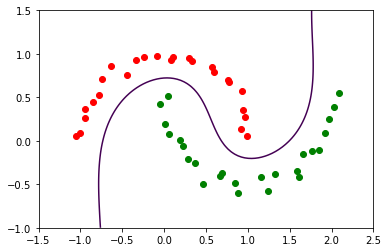

In [38]:
# CHANGE THE VALUES IN THE TWO LINES BELOW:
C = 100
gamma = 1.0

svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(trainingdata,trainingclasses)

X1, X2 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.0, 1.5, 100))
X_grid = np.c_[X1.ravel(), X2.ravel()]
decision_values = svm.decision_function(X_grid)
fill_levels = [decision_values.min()] + [0] + [
            decision_values.max()]

for s in range(nclusters):
    plt.scatter(trainingdata[(trainingclasses == s),0],trainingdata[(trainingclasses == s),1],marker='o', color=color[s])
ax = plt.gca()
ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=[0])

#### Over-fitting 

You should see that as `gamma` is made larger the shape of the decision boundary follows the data more and more closely. This is not necessarily a good thing. Can you think why? Below I train the SVM on the training data using a very large value of gamma, but plot the decision boundary along with the test data and the predicted classes. This is a case of "over-fitting" of the training data to the point where new cases are frequently mis-classified:


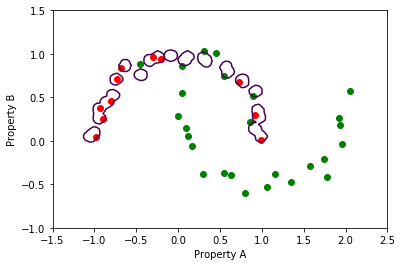

In [39]:
C = 100
gamma = 1000.0

svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(trainingdata,trainingclasses)

X1, X2 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.0, 1.5, 100))
X_grid = np.c_[X1.ravel(), X2.ravel()]
decision_values = svm.decision_function(X_grid)
fill_levels = [decision_values.min()] + [0] + [
            decision_values.max()]

predictedclasses = svm.predict(testdata)

for s in range(nclusters):
    plt.scatter(testdata[(predictedclasses == s),0],testdata[(predictedclasses == s),1],marker='o', color=color[s])
plt.xlabel('Property A')
plt.ylabel('Property B')
ax = plt.gca()
ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=[0])

### Neural networks
We discussed some of the ideas and theory behind neural networks in the lectures, but here is a brief reminder:

ADD DETAILS

#### A Classification problem
We will now illustrate the use of a simple neural network to implement a classification of a set of moon-shaped clusters. This is an alternative approach to the one that we adopted above with a support vector machine. This time we will use a slightly more challenging data set in order to explore the issue of over-fitting. First let's load and examine the data:

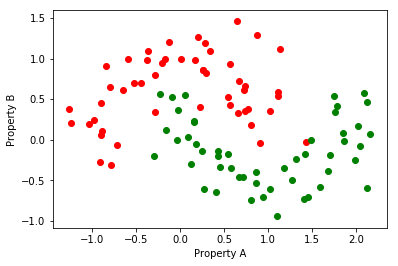

In [40]:
data = np.loadtxt('Data/moonclusterdata2.txt', delimiter=',')
classes = np.loadtxt('Data/moonclusterclasses2.txt', delimiter=',')

nclusters = 2
color = ['r','g','b']
for s in range(nclusters):
    plt.scatter(data[(classes == s),0],data[(classes == s),1],marker='o', color=color[s])
plt.xlabel('Property A')
plt.ylabel('Property B')

Notice that there is much more scatter in these clusters, which will make them harder to distinguish.

As we discussed below, in order to validate a model we will need both a set of training data and a separate set of test data, for which we know the classes (the "correct answers") but which the trained machine has never seen before. Scikit-learn contains a function to split out a set of data into two groups, as below:

In [53]:
data_train, data_test, classes_train, classes_test = sklearn.model_selection.train_test_split(data, classes, stratify=classes, random_state=42)
print(str(np.size(data_train,0)) + ' elements in training set, ' + str(np.size(data_test,0)) + ' elements in test set.')

75 elements in training set, 25 elements in test set.


We are going to use a *Multi-layer perceptron* (MLP) network, so we need to import the necessary functionality:

In [42]:
from sklearn.neural_network import MLPClassifier

Now let's create an `mlp` object and train it using the training data:

In [43]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10,10] , activation='tanh').fit(data_train, classes_train)

The most important parameters for the MLP are the *solver* <span style="color: red"> (Comment: What does lbfgs stand for?)</span> which defines the algorithm used to train the network and the hidden layer sizes. In this case we are defining a network with two hidden layers <span style="color: red"> (Comment: What are hidden layers?)</span>, with 10 elements each. Finally, we also specify that the *activation function* used by each element will be a tanh function.

#### <span style="color: red"> Comment: Could we explain why the hidden layers have 10 elements and why the activation function is a tanh function? What does the activation function do?

One way to regard a neural network is that it is a way to fit a completely general non-linear function <span style="color: red"> (Comment: To what?)</span>. In this case, that function will define a decision boundary for classifying new data, just as for the SVM that we investigated previously. We can visualise this decision boundary as follows:

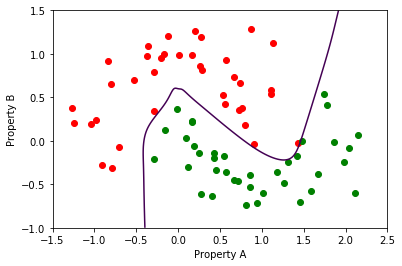

In [44]:
X1, X2 = np.meshgrid(np.linspace(-1.5, 2.5, 1000), np.linspace(-1.0, 1.5, 1000))
X_grid = np.c_[X1.ravel(), X2.ravel()]
decision_values = mlp.predict_proba(X_grid)[:, 1]
fill_levels = [decision_values.min()] + [0] + [
            decision_values.max()]

for s in range(nclusters):
    plt.scatter(data_train[(classes_train == s),0],data_train[(classes_train == s),1],marker='o', color=color[s])
ax = plt.gca()
ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=[0.5])
plt.xlabel('Property A')
plt.ylabel('Property B')

This looks reasonable, but remember that we need to validate the trained model against the test set. So let's use the trained network to classify the test data:

In [45]:
classes_predicted = mlp.predict(data_test)

We can evaluate the quality of the network based on what fraction of the test data are correctly classified:

In [46]:
print('Percentage correctly classified: ' + str(np.sum(classes_test==classes_predicted)/np.size(classes_test)*100) + '%')

Percentage correctly classified: 92.0%


Not bad. In fact, we don't need to calculate this performance metric ourselves: as you might expect, scikit-learn has functions to do it for us:

In [47]:
mlp.score(data_test,classes_test)

0.92000000000000004

We can also visualise this performance by plotting the true classes of the test data along with the decision boundary:

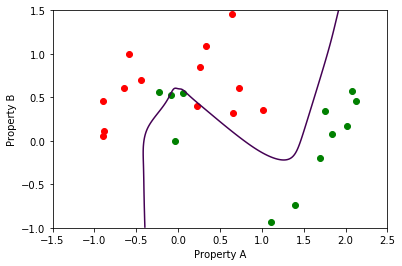

In [48]:
for s in range(nclusters):
    plt.scatter(data_test[(classes_test == s),0],data_test[(classes_test == s),1],marker='o', color=color[s])
ax = plt.gca()
ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=[0.5])
plt.xlabel('Property A')
plt.ylabel('Property B')

We can see that the decision boundary isn't quite right for a few of the points.

#### Overfitting
When we discussed the support vector machine, we found that if we optimised the decision boundary too finely for the training data then we ended up with poor results when we attempted to classify the test data. This is a general result and is referred to as *over-fitting*. We need to guard against it. 

In the case of a MLP neural network, we might make the mistake of using too a large number of neurons in the hidden layers. This would give a very detailed fit to the training data. Let's try a network with two layers of 100 elements each and plot the resulting boundary against the test data (note that this might take a little while to complete):

Score:  0.88


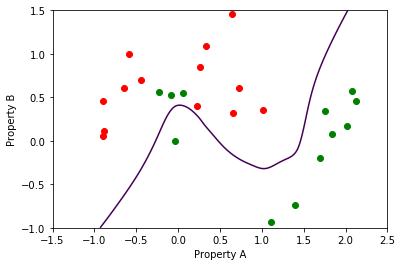

In [49]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[100,100] , activation='tanh').fit(data_train, classes_train)
classes_predicted = mlp.predict(data_test)
print('Score: ', mlp.score(data_test,classes_test))

X1, X2 = np.meshgrid(np.linspace(-1.5, 2.5, 1000), np.linspace(-1.0, 1.5, 1000))
X_grid = np.c_[X1.ravel(), X2.ravel()]
decision_values = mlp.predict_proba(X_grid)[:, 1]
fill_levels = [decision_values.min()] + [0] + [
            decision_values.max()]

for s in range(nclusters):
    plt.scatter(data_test[(classes_test == s),0],data_test[(classes_test == s),1],marker='o', color=color[s])
ax = plt.gca()
ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=[0.5])
plt.xlabel('Property A')
plt.ylabel('Property B')

Our more sophisticated (larger) network has a worse performance on the test set. One way to guard against over-fitting is to systematically explore a range of values for the parameters of the model that you are using (in this case the size of the hidden layers) and plot the performance of the network against both the training and the test set as a function of the parameters. Below we do this for the case of the two layer MLP:

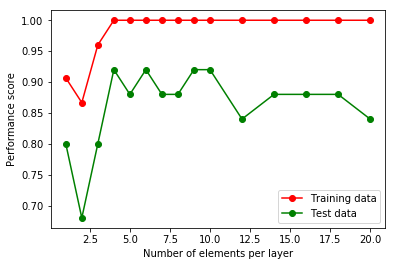

In [50]:
nunits = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
score_train=[]
score_test=[]
for s in nunits:
    mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[s,s], activation='tanh').fit(data_train, classes_train)
    score_train.append(mlp.score(data_train,classes_train))
    score_test.append(mlp.score(data_test,classes_test))
plt.plot(nunits,score_train,'ro-', label="Training data")
plt.plot(nunits,score_test,'go-', label="Test data")
plt.legend()
plt.xlabel('Number of elements per layer')
plt.ylabel('Performance score')

What do we see? First, as the size of the network increases, the performance against the training set gradually increases. This makes sense, because more elements in the hidden layers will give a decision boundary that more finely fits the details of the training set. However, we see that there is an optimum value for the network size against the test set. Once we get above 4 elements per hidden layer the model starts to over-fit the training data and performance against the test data plateaus and even begins to degrade.

#### <span style="color: red"> Task 5:</span>   Copy the above code and use it to explore the performance of a *single-layer* MLP as a function of network size. (hint: you will need to specify the network size with a single number as follows:   `hidden_layer_sizes=[s]`.)

#### <span style="color: red"> Solution:</span>  

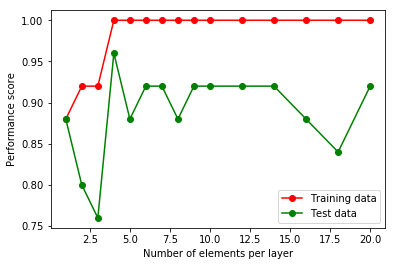

In [51]:
nunits = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
score_train=[]
score_test=[]
for s in nunits:
    mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[s], activation='tanh').fit(data_train, classes_train)
    score_train.append(mlp.score(data_train,classes_train))
    score_test.append(mlp.score(data_test,classes_test))
plt.plot(nunits,score_train,'ro-', label="Training data")
plt.plot(nunits,score_test,'go-', label="Test data")
plt.legend()
plt.xlabel('Number of elements per layer')
plt.ylabel('Performance score')

You might find that the optimised single-layer network performs slightly better than the two-layer network. This is probably just luck, as we can see if we show the decision boundaries from the optimised single and dual layer networks together. The performance is very sensitive to the details of the shape of the boundary in a small region around (0.0,0.5) in property space:

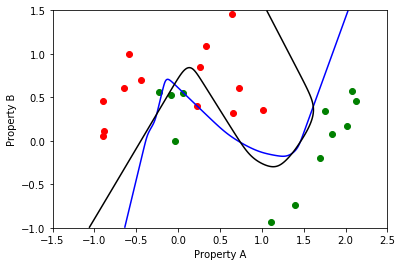

In [52]:
X1, X2 = np.meshgrid(np.linspace(-1.5, 2.5, 1000), np.linspace(-1.0, 1.5, 1000))
X_grid = np.c_[X1.ravel(), X2.ravel()]

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[4] , activation='tanh').fit(data_train, classes_train)
decision_values_single = mlp.predict_proba(X_grid)[:, 1]
fill_levels_single = [decision_values.min()] + [0] + [
            decision_values.max()]

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[4,4] , activation='tanh').fit(data_train, classes_train)
decision_values_double = mlp.predict_proba(X_grid)[:, 1]
fill_levels_double = [decision_values.min()] + [0] + [
            decision_values.max()]

for s in range(nclusters):
    plt.scatter(data_test[(classes_test == s),0],data_test[(classes_test == s),1],marker='o', color=color[s])
ax = plt.gca()
ax.contour(X1, X2, decision_values_single.reshape(X1.shape), levels=[0.5], colors=('b'))
ax.contour(X1, X2, decision_values_double.reshape(X1.shape), levels=[0.5], colors=('k'))
plt.xlabel('Property A')
plt.ylabel('Property B')

## An application of machine learning: classifying microstructure

We will now take what we have learned and apply it to a real research problem. The rest of the material for this session is in the second Machine Learning notebook